In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import random

from sklearn.datasets import fetch_lfw_people
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

from PIL import Image

model = VGG16(weights='imagenet', include_top=False)
model.summary()



Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
bloc

In [2]:

def load_image( infilename ) :
    img = Image.open( infilename ).convert("L")
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data

cwd = os.getcwd()

train_dir = cwd + "/CS3244_Project_Images/train/"

ship_types = ["Container", "FireFightingVessel", "HeavyLoadCarrier", 
"Passenger", "Platform", "Reefer", "ReplenishmentVessel", "SupplyVessel", "Training", "Tug"]

ships = {
    "data": [], 
    "target": [], 
}


In [ ]:

for ship_type in ship_types:
    curr_ship_dir = train_dir + ship_type
    for file in os.listdir(curr_ship_dir):
        img = image.load_img(curr_ship_dir + "/" + str(file), target_size=(224, 224))
        img_data = image.img_to_array(img)
        img_data = np.expand_dims(img_data, axis=0)
        img_data = preprocess_input(img_data)

        resnet_feature = model.predict(img_data)
        
        ships["data"].append(resnet_feature.flatten())
        ships["target"].append(ship_type)

print("Finish parsing images")


In [25]:


Xtrain, Xtest, ytrain, ytest = train_test_split(np.asarray(ships["data"]), 
np.asarray(ships["target"]), random_state=43)


In [26]:
pca = PCA(n_components=128, whiten=True, svd_solver="auto")
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

param_grid = {'svc__C': [0.1, 0.5, 1, 5, 10, 50],
              'svc__gamma': [0.001, 0.005, 0.01, 0.05]}
clf = GridSearchCV(model, param_grid, iid=False, cv=7)


In [27]:
clf.fit(Xtrain, ytrain)
print("Finish training model...")
print(clf.best_params_)


Finish training model...
{'svc__gamma': 0.01, 'svc__C': 50}


In [29]:
model = clf.best_estimator_
yfit = model.predict(Xtest)

                     precision    recall  f1-score   support

          Container       0.48      0.80      0.60        44
 FireFightingVessel       0.50      0.57      0.53        58
   HeavyLoadCarrier       0.53      0.46      0.49        68
          Passenger       0.60      0.58      0.59        77
           Platform       0.74      0.79      0.76        61
             Reefer       0.33      0.44      0.37        80
ReplenishmentVessel       0.42      0.39      0.40        67
       SupplyVessel       0.52      0.33      0.41        69
           Training       0.76      0.64      0.69        97
                Tug       0.46      0.37      0.41        52

          micro avg       0.53      0.53      0.53       673
          macro avg       0.53      0.54      0.53       673
       weighted avg       0.54      0.53      0.53       673



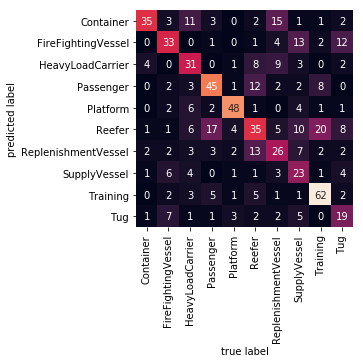

In [30]:
print(classification_report(ytest, yfit, target_names=ship_types))
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=ship_types,
            yticklabels=ship_types)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()